In [2]:
# loading libraries

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve


/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Entre cada uno de los integrantes del grupo fuimos obteniendo distintos features que nos parecieron interesantes y que consideramos que podrian servir para las predicciones.

#### Leemos los distintos CSVs que contienen los features


In [3]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv').drop(columns='Unnamed: 0')
features_ari = pd.read_csv('../features/features_ariel.csv')
features_mati = pd.read_csv('../features/features_frecuencia.csv')
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')
features_gonza2 = pd.read_csv('../features/features_gonza2.csv')

## Mergeamos todos los features en un solo dataframe de la forma <persona, feature1, feature2,...,...>

In [4]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza2, how='inner', on='person')
#model_df = pd.merge(model_df, features_mati, how='inner', on='person')
model_df.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,checkout,generic listing,searched products,viewed product,visited site,completa_flujo,favorite_device_Computer,favorite_device_Smartphone,favorite_device_Tablet,favorite_device_Unknown
0,0008ed71,1,0,0,0,0,0,0,0,0,...,3.0,1.0,NaN,NaN,2.0,False,1,0,0,0
1,00091926,1,0,0,0,0,0,0,0,0,...,2.0,NaN,NaN,372.0,34.0,False,1,0,0,0
2,00091a7a,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,3.0,1.0,False,0,1,0,0
3,000ba417,0,0,0,0,0,0,0,1,0,...,6.0,14.0,NaN,153.0,6.0,False,1,0,0,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,1.0,1.0,9.0,3.0,1.0,False,0,1,0,0


In [5]:
model_df.fillna(value=0, inplace=True)

## Al dataframe de las personas con sus features le agregamos los labels para saber si cada persona o no realizo una compra.

## Tambien tenemos un dataframe de test, el cual contiene todas las personas que queremos predecir y sus features ( queremos predecir sus labels)

In [6]:
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')
#training_set.drop(columns= 'Unnamed: 0', inplace=True)

## Como se puede observar en nuestro set de entrenamiento predomina el label 0, la mayoria de las personas no realizo una conversion, esto debemos balancearlo.

In [7]:
training_set['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

## Elimino 17500 filas que contienen el label 0 para balancear el set de entrenamiento.

# <font color='red'> Preguntar de cual es la mejor manera de hacer esto</font>

In [8]:
#training_set.sort_values(by='month_moda', ascending=True, inplace=True)
#r_training_set = training_set.drop(training_set[training_set.label.eq(0)].head(17500).index)

In [9]:
#r_training_set = training_set.drop(training_set[training_set.label.eq(0)].sample(17454).index)
#r_training_set['label'].value_counts()

In [10]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19414 entries, 0 to 19413
Data columns (total 65 columns):
person                                   19414 non-null object
marca_favorita_apple                     19414 non-null int64
marca_favorita_asus                      19414 non-null int64
marca_favorita_lenovo                    19414 non-null int64
marca_favorita_lg                        19414 non-null int64
marca_favorita_motorola                  19414 non-null int64
marca_favorita_no tiene                  19414 non-null int64
marca_favorita_quantum                   19414 non-null int64
marca_favorita_samsung                   19414 non-null int64
marca_favorita_sony                      19414 non-null int64
nivel_de_actividad_Muy Bajo              19414 non-null int64
nivel_de_actividad_Bajo                  19414 non-null int64
nivel_de_actividad_Medio                 19414 non-null int64
nivel_de_actividad_Alto                  19414 non-null int64
nivel_de_actividad_Muy

In [18]:
buyers = training_set.loc[training_set.label == 1]
not_buyers = training_set.loc[training_set.label == 0]

In [ ]:
for i in buyers.columns:
    print i
    print buyers[i].value_counts()

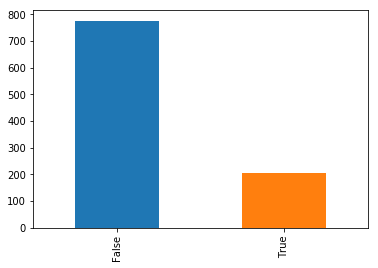

In [17]:
buyers['completa_flujo'].value_counts().plot.bar()

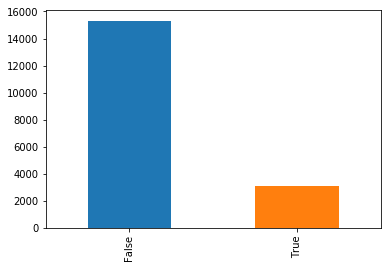

In [19]:
not_buyers['completa_flujo'].value_counts().plot.bar()

In [92]:
buyers['cantidad_checkouts'].value_counts()

0.0     531
1.0     161
2.0      84
3.0      64
4.0      41
6.0      19
5.0      16
7.0      12
8.0      10
9.0       6
12.0      5
13.0      5
10.0      4
19.0      3
15.0      2
47.0      2
11.0      2
21.0      2
14.0      2
17.0      2
29.0      2
27.0      1
33.0      1
66.0      1
24.0      1
20.0      1
Name: cantidad_checkouts, dtype: int64

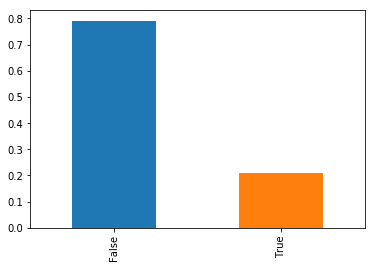

In [122]:
buyers['completa_flujo'].value_counts(normalize=True).head(15).plot.bar()

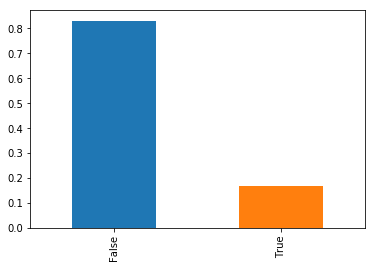

In [123]:
not_buyers['completa_flujo'].value_counts(normalize=True).head(15).plot.bar()

## En el siguiente array incluimos los features que mas aportan para las predicciones

In [179]:
features = [#'cant_total_eventos', #f1
            'marca_favorita_apple',#f2
            'mean_events_per_day',#f3
            #'has_converted_before',#f4
            #'most_viewed_sku',#f5
            #'most_viewed_color_Preto',#f6
            #'most_viewed_color_Branco',#f7
            #'most_viewed_color_Dourado', #f8
            #'region_brasil_Sao Paulo',#f9
            #'region_brasil_Unknown',#f10
            #'region_brasil_Minas Gerais',#f11
            'marca_favorita_samsung',#f12
            #'cant_ev_noche',#f13
            #'cant_ev_manana',#f14
            #'cant_ev_tarde',#f15
            #'cant_ev_madrugada',#f16
            #'cant_buenos',#f17
            #'cant_muy_buenos',#f18
            #'cant_excelentes',#f19
            #'nivel_de_actividad_Muy Bajo',#f20
            #'nivel_de_actividad_Muy Alto',#f21
            #'nivel_de_actividad_Bajo',#f22
            #'nivel_de_actividad_Medio',#f23
            #'nivel_de_actividad_Alto',#f24
            #'favorite_device_Smartphone',#f25
            'favorite_device_Computer',#f26
            'cantidad_checkouts',#f27
            'cantidad_conversions',#f28
            'tasa_cc',
            'viewed product',
            #'cantidad_lead',
            #'searched products',
            #'first_and_last_event_distance_in_days',
            #'month_moda',
            'completa_flujo'
           ]

## Creo dos arrays el llamado X es generado a partir de mi dataframe de entrenamiento y los features que quiero tener en cuenta
## Y el segundo Y es generado a partir de sus labels

In [180]:
x = np.array(training_set[features])
y = np.array(training_set['label'])

## Usamos train_test_split para dividir el dataframe de entrenamiento en uno de test y otro de entrenamiento

In [181]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

## El primer algoritmo que utilizamos es KNN

### En el siguiente loop iremos probando KNN con distintos Ks y nos quedaremos con la que obtuvimos mayor accuracy.

In [182]:
best_accuracy = 0
worst_accuracy = 1
best_k = 1
worst_k = 0
best_prediction = []
#acumulated_acuracy = 0
#loop_count = 0;

for i in xrange(1,203,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = (knn.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test,pred.round(), normalize=False)
    if (accuracy > best_accuracy) :
        best_k = i
        best_accuracy = accuracy
        best_prediction = pred
    if (accuracy < worst_accuracy) : 
        worst_accuracy = accuracy
        worst_k = i
    #loop_count += 1
    #acumulated_acuracy += accuracy
    #X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)
        

In [183]:
print 'Best accuracy: ' + str(best_accuracy / float(best_prediction.size)) + ' with k='  + str(best_k)
print 'Worst accuracy: ' + str(worst_accuracy / float(best_prediction.size)) + ' with k= ' + str(worst_k)
#print "Median accuracy " + str(acumulated_acuracy / (float(loop_count) * float(best_prediction.size)))

Best accuracy: 0.9451455060520216 with k=7
Worst accuracy: 0.000257532835437 with k= 0


## Finalmente corremos KNN con el mejor K obtenido en el entrenamiento y el set que queremos predecir

In [184]:
z = np.array(test_set[features])
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x,y)
pred = knn.predict_proba(z)[:,1]

## Le agregamos las predicciones a los IDs de las personas y lo guardamos en un archivo.


In [185]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/knn.csv', index=False)

## Revisamos la cantidad de conversiones y no conversiones predichas

### Se tienen que repartir en un 50/50

In [186]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 19390
Cantidad de conversiones: 25


## XGBoost

### En los siguientes arrays, ponemos los posibles hiperparametros que concideramos que mejor funcionarian para las predicciones.

### Con grid search probamos todas las combinaciones posibles y nos quedamos con la que mayor accuracy nos dio.

In [187]:
#n_estimators = [100, 200, 1500, 2000]
max_depth = [2, 4, 6, 8]
scale_pos_weight = [4, 6, 8, 18]

#learning_rate = [0.0001, 0.001, 0.01]
#subsample = [0.3, 0.5, 0.7]
#gamma = [0.6, 0.7]
#colsample_bytree = [0.5, 0.7]

#param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,
#                 learning_rate=learning_rate, subsample=subsample,
#                 gamma=gamma)

param_grid = dict(max_depth=max_depth, scale_pos_weight=scale_pos_weight)


In [188]:
#xgboost = xgb.XGBClassifier()
#kfold = StratifiedKFold(n_splits = 2, shuffle=True, random_state=7)
#grid_search = GridSearch(xgboost, param_grid, scoring="neg_log_loss", n_jobs = 1, cv=kfold, verbose=1)
#result = grid_search.fit(x,y)

In [189]:
#pred = (xgboost.predict_proba(z)[:,1])

In [190]:
#pred

In [191]:
#print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [192]:
#means = result.cv_results_['mean_test_score']
#stds = result.cv_results_['std_test_score']
#params = result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

### Corremos XGBoost para el set de entrenamiento y medimos su precision

In [198]:
#xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
#                            n_estimators= 2000,\
#                            max_depth= 4,\
#                            min_child_weight= 2,\
#                            gamma=0.7,\
#                            subsample=0.7,\
#                            colsample_bytree=0.7,\
#                            objective= 'binary:logistic',\
#                            scale_pos_weight=(negative/positive)
#                           )

for w in [10,15,18,20,26,30]:
    xgboost = xgb.XGBClassifier(learning_rate = 0.1,\
                                n_estimators= 1000,\
                                max_depth= 5,\
                                #min_child_weight= 1,\
                                gamma=0,\
                                subsample=0.8,\
                                colsample_bytree=0.8,\
                                objective= 'binary:logistic',\
                                scale_pos_weight= 1,
                                seed=27
                               )

    xgboost.fit(X_train, y_train, eval_metric='aucpr')
    pred = (xgboost.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, pred.round(), normalize=False)

    print("Accuracy: ", accuracy / float(pred.size))

    for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
        else: 
            pred[i] = 0

    print('---Classification Report---')
    print('Weight: ' + str(w))
    print(classification_report(y_test,pred))

('Accuracy: ', 0.8908060777749163)
---Classification Report---
Weight: 10
             precision    recall  f1-score   support

          0       0.96      0.92      0.94      3670
          1       0.20      0.34      0.25       213

avg / total       0.92      0.89      0.90      3883

('Accuracy: ', 0.8552665464846768)
---Classification Report---
Weight: 15
             precision    recall  f1-score   support

          0       0.97      0.87      0.92      3670
          1       0.20      0.53      0.29       213

avg / total       0.93      0.86      0.88      3883

('Accuracy: ', 0.8326036569662632)
---Classification Report---
Weight: 18
             precision    recall  f1-score   support

          0       0.97      0.85      0.91      3670
          1       0.18      0.59      0.28       213

avg / total       0.93      0.83      0.87      3883

('Accuracy: ', 0.816121555498326)
---Classification Report---
Weight: 20
             precision    recall  f1-score   support

      

In [196]:
x_test_df = pd.DataFrame(data=X_test, columns=features)
x_test_df['index'] = x_test_df.index
x_label_pred = pd.DataFrame({'label': y_test, 'pred': pred})
x_label_pred['index'] = x_label_pred.index

In [96]:
merged = pd.merge(x_test_df, x_label_pred, how='inner', on='index')
falsos_positivos = merged.loc[(merged['label'] == 1) & (merged['pred'] < 0.5)]['label'].count()
falsos_negativos = merged.loc[(merged['label'] == 0) & (merged['pred'] >= 0.5)]['label'].count()
unos = merged.loc[(merged['label'] == 1) & (merged['pred'] >= 0.5)]['label'].count()
ceros = merged.loc[(merged['label'] == 0) & (merged['pred'] < 0.5)]['label'].count()

In [97]:
print '1s predichos como 0s: '+ str(falsos_positivos)
print '0s predichos como 1s: '+ str(falsos_negativos)
print '1s bien predichos: ' + str(unos)
print '0s bien predichos: ' + str(ceros)

1s predichos como 0s: 18
0s predichos como 1s: 1458
1s bien predichos: 161
0s bien predichos: 2246


## Analizamos cuales son los features que mayor peso tienen para xgboost.

In [98]:
print(xgboost.feature_importances_)

[0.1615276  0.00757857 0.10873765 0.00341779 0.00356639 0.00445798
 0.00159744 0.00442083 0.04914927 0.02975704 0.04502563 0.04353964
 0.06790995 0.03466082 0.03239468 0.03588677 0.05353295 0.06423211
 0.05568764 0.07500558 0.02804815 0.08986552]


In [99]:
fi = pd.DataFrame({'features': features, 'importancia': xgboost.feature_importances_})
#fi.sort_values(ascending=False, by='importancia').plot.bar()
fi.sort_values(by='importancia', ascending=False)

,features,importancia
0,cant_total_eventos,0.161528
2,mean_events_per_day,0.108738
21,first_and_last_event_distance_in_days,0.089866
19,tasa_cc,0.075006
12,cant_buenos,0.067910
17,cantidad_checkouts,0.064232
18,cantidad_conversions,0.055688
16,favorite_device_Computer,0.053533
8,cant_ev_noche,0.049149
10,cant_ev_tarde,0.045026


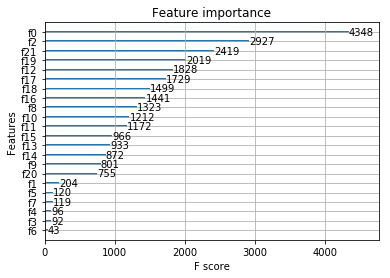

In [100]:
plot = plot_importance(xgboost)
#plot.set_yticklabels(features, fontdict=None, minor=False)
pyplot.show()

In [70]:
negative = training_set.loc[training_set['label'] == 0]['label'].count()
positive = training_set.loc[training_set['label'] == 1]['label'].count()

In [149]:
xgboost = xgb.XGBClassifier(learning_rate = 0.0001,\
                                n_estimators= 2000,\
                                max_depth= 4,\
                                min_child_weight= 2,\
                                gamma=0.9,\
                                subsample=0.7,\
                                colsample_bytree=0.7,\
                                objective= 'binary:logistic',\
                                scale_pos_weight= w
                               )

xgboost.fit(x,y, eval_metric='aucpr')
pred = (xgboost.predict_proba(z)[:,1])

In [150]:
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)

In [151]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 11097
Cantidad de conversiones: 8318


In [152]:
submit['label'].mean()

0.49179837107658386